In [1]:
from networks.UNet import LitUNet
from lightning import Trainer
# from torch.nn.functional import softmax
import os
# from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
# import torch
from glob import glob
from data.dataset import OEMMiniDataset
from torch.utils.data import DataLoader
from pathlib import Path

In [2]:
# map_location = {'cuda:0':'cpu'}
ckpt_pth = glob('/home/ubuntu/hrl/oem_mini_experiments/.neptune/Untitled/MIN-38/checkpoints/*.ckpt')
model = LitUNet.load_from_checkpoint(checkpoint_path=ckpt_pth[0], map_location='cpu')
trainer = Trainer(accelerator='gpu',num_nodes=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [3]:
DATA_DIR = "/home/ubuntu/hrl/oem_mini_experiments/data/processing/OpenEarthMap_Mini"
VAL_LIST = os.path.join(DATA_DIR, "val.txt")
fns = [f for f in Path(DATA_DIR).rglob("*tif") if "/images/" in str(f)]
print(len(fns))
fns = [f for f in fns if os.path.exists(str(f).replace('/images/', '/labels/'))]
print(len(fns))
val_list = [str(f)
            for f in fns
            if "_".join(f.name.split("_")[:-2]) + ".tif"
            in np.loadtxt(VAL_LIST, dtype=str)
        ]
print(len(val_list))

1068
755
0


In [25]:
# val_list = val_list[:100]
val_list = fns[:200]

In [26]:
def pred_labels(trainer, dataloader):
    preds = trainer.predict(model, dataloaders=dataloader)
    # preds = torch.argmax(softmax(input=preds, dim=1), dim=1).permute(1,2,0).numpy()
    return preds

In [27]:
OEM_pred = DataLoader(OEMMiniDataset(img_list=val_list, testing=False, augm=None), shuffle=False)

In [28]:
pred_labels = pred_labels(trainer=trainer, dataloader=OEM_pred)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [29]:
true = np.concatenate([preds[1].flatten() for preds in pred_labels])
pred = np.concatenate([preds[0].flatten() for preds in pred_labels])

In [30]:
import seaborn as sns
import pandas as pd

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true, pred, normalize='true')

In [32]:
np.unique(true, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 1871254,  4078177, 51277152, 31185747, 11233270, 43996024,
         7357201, 32562799, 26153576]))

In [33]:
np.unique(pred, return_counts=True)

(array([2, 3, 4, 5, 6, 7, 8]),
 array([48765316, 33699629, 12397111, 51148766,  9003756, 29414182,
        25286440]))

In [34]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = list(np.unique([true, pred])), 
                     columns = list(np.unique([true, pred]))
                     )

In [35]:
cm_df.head()

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.949403,0.025273,0.002225,0.002732,0.015100,0.004343,0.000923
1,0.0,0.0,0.197360,0.449649,0.005776,0.180952,0.110476,0.055499,0.000289
2,0.0,0.0,0.668156,0.061261,0.010302,0.181985,0.015906,0.054018,0.008372
3,0.0,0.0,0.069182,0.732045,0.071834,0.025269,0.009778,0.014660,0.077233
4,0.0,0.0,0.023480,0.150614,0.798627,0.012078,0.004931,0.005758,0.004511


In [36]:
drop_cm = cm_df
drop_cm = cm_df.drop([0], axis=0)
drop_cm = drop_cm.drop([0], axis=1)
drop_cm

,1,2,3,4,5,6,7,8
1,0.0,0.197360,0.449649,0.005776,0.180952,0.110476,0.055499,0.000289
2,0.0,0.668156,0.061261,0.010302,0.181985,0.015906,0.054018,0.008372
3,0.0,0.069182,0.732045,0.071834,0.025269,0.009778,0.014660,0.077233
4,0.0,0.023480,0.150614,0.798627,0.012078,0.004931,0.005758,0.004511
5,0.0,0.082768,0.012115,0.003226,0.884660,0.002800,0.012230,0.002201
6,0.0,0.040435,0.027465,0.014508,0.018476,0.861715,0.033412,0.003989
7,0.0,0.158740,0.011636,0.003795,0.026059,0.021722,0.766564,0.011485
8,0.0,0.015047,0.116316,0.009845,0.009340,0.006834,0.005454,0.837164


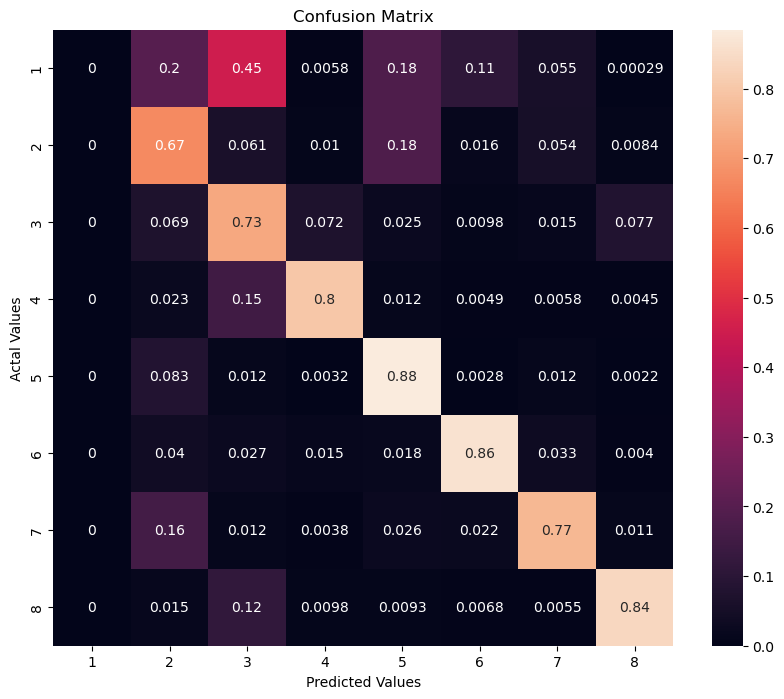

: 

In [37]:
#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(drop_cm, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()